# Introduction

**Context**

A company in Big Data and Data Science aims to recruit data scientists from its training program. While many candidates enroll, the company wants to identify who intends to join after dataseting versus those seeking other jobs. This helps reduce costs, improve dataseting quality, and guide course planning.

**Content**

The dataset includes demographics, education, and experience collected at enrollment. Using this information, predictive models can estimate the probability of a candidate looking for new employment and highlight the key factors influencing such decisions, offering insights valuable for both recruitment and HR research.

The dataset below is fetched from Kaggle. Here's link to the dataset: [Link](https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists/data)

**Feature**

* enrollee_id : Unique ID for candidate.
* city: City code.
* city_ development _index : Development index of the city (scaled).
* gender: Gender of candidate.
* relevent_experience: Relevant experience of candidate.
* enrolled_university: Type of University course enrolled if any.
* education_level: Education level of candidate.
* major_discipline :Education major discipline of candidate.
* experience: Candidate total experience in years.
* company_size: Number of employees in current employer's company.
* company_type : Type of current employer's company.
* last_new_job: Difference in years between previous job and current job.
* training_hours: training hours completed.
* target: 0 – Not looking for job change, 1 – Looking for a job change.


**Outcome**

We want to find out which data scientists among the people who pass some courses from the survey conducted by the company is mostly likely to want to work for their company after training (0) or looking for a new job (1), making this a *classification* task.

# Import library and mount dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy.stats import randint

In [3]:
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset\aug_test.csv
dataset\aug_train.csv


In the original file, the testing dataset does not include target column; Therefore, I will not use it and use only the training dataset to split into training and testing data.

In [2]:
dataset = pd.read_csv('dataset/aug_train.csv')

In [3]:
dataset

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


# EDA

## Data Exploration

In this step, we are going to explore if our dataset has any missing value, explore unique value in each attribute and a correlation between them.

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

From here, you can tell that only 4 of the columns (enrollee_id, city_development_index, training_hours, and target) in the dataset is numerical, while the rest are Categorical variable.

In [7]:
dataset.shape

(19158, 14)

In [8]:
dataset.nunique()

enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   22
company_size                  8
company_type                  6
last_new_job                  6
training_hours              241
target                        2
dtype: int64

As we can see right here, the enrollee_id is the unique id for every employee, so therefore, we will explore the frequency every value appear in the dataset expect for enrollee_id.

In [9]:
skip_col = ['enrollee_id']

# Loop through all columns except the skipped one
for col in dataset.columns:
    if col not in skip_col:
        print(f"Value counts for {col}:")
        print(dataset[col].value_counts())
        print("-" * 30)

Value counts for city:
city
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: count, Length: 123, dtype: int64
------------------------------
Value counts for city_development_index:
city_development_index
0.920    5200
0.624    2702
0.910    1533
0.926    1336
0.698     683
         ... 
0.649       4
0.807       4
0.781       3
0.625       3
0.664       1
Name: count, Length: 93, dtype: int64
------------------------------
Value counts for gender:
gender
Male      13221
Female     1238
Other       191
Name: count, dtype: int64
------------------------------
Value counts for relevent_experience:
relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64
------------------------------
Value counts for enrolled_university:
enrolled_university
no_enrollment       13817
Full time course     3757


From the exploration, we see that 

1. Most candidates come from city_103 (4,355), followed by city_21 (2,702), which aligns with the highest city_development_index (0.920) — suggesting that more candidates live in highly developed cities.

2. The dataset is male-dominated (≈13,200 males vs. 1,200 females), and most have relevant experience (13,792). 

3. A large portion of candidates are not currently enrolled in a university course (13,817) and hold a Graduate degree (11,598), with the majority having a STEM background (14,492).

4. Regarding experience, most participants have over 20 years of experience (3,286), followed by 3–6 years. 

5. Company size distribution shows that many work in medium to large firms (50–99 or 100–500 employees), and most are employed at private companies (9,817).

6. For last_new_job, the most common interval is 1 year (8,040), meaning many changed jobs recently. 

7. The majority completed fewer than 30–50 training hours, showing that extensive training is uncommon.

8. Finally, the target variable indicates a class imbalance, with 14,381 (75%) not looking for a job change and 4,777 (25%) looking for one — something important to address before modeling (e.g., through resampling or class weighting).

In [10]:
dataset.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [11]:
percentage_missing = (dataset.isnull().sum() / len(dataset)) * 100
print("\nPercentage of missing values per column:\n",percentage_missing)


Percentage of missing values per column:
 enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64


Missing value cases are seen in 8 column, where company size and type has the highest missing value, in the contrast with gender and major_discipline has moderate span of missing value, and enrolled_university, with education_level, last_new_job and experience, have the least missing value case that less than 3%.

Interestingly, no missing value is in numeric attribute.

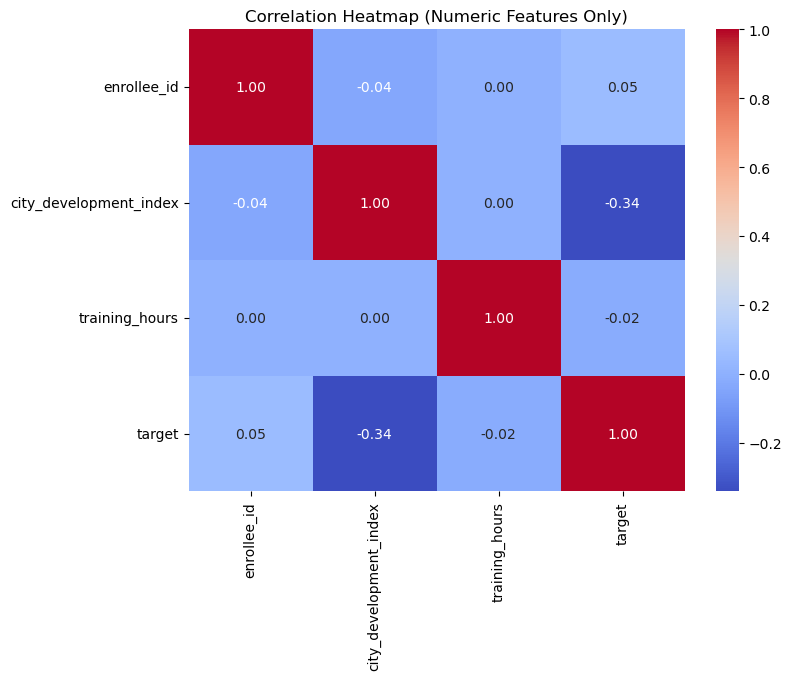

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = dataset.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

Here, we see a correlation analysis shows a moderate negative relationship (-0.34) between city_development_index and target, suggesting that candidates from less developed cities are more likely to look for new jobs. In contrast, training_hours has almost no correlation with job change, and enrollee_id has no predictive value. Overall, city development appears to be an important factor influencing job change behavior.

In [13]:
dataset.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


## Data Visualization

In this stage, we are going to explore the dataset by comparing each of them with target column to extract some insight.

### City Development index

<Axes: xlabel='city_development_index', ylabel='Count'>

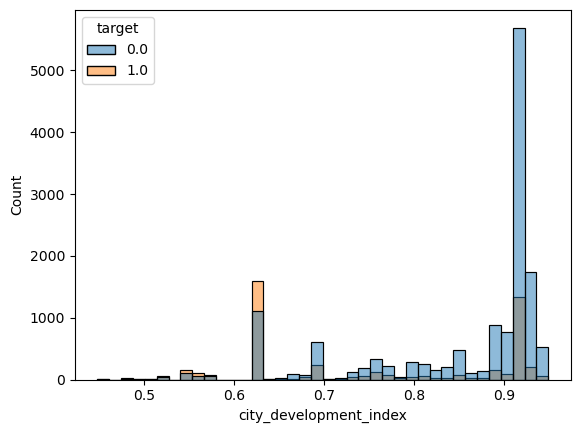

In [ ]:
sns.histplot(data= dataset,  x="city_development_index", hue = "target")

Here, we see the distribution of the city_development_index is highly skewed toward 1.0, indicating that most candidates come from well-developed cities. Only a few data points fall below 0.5, showing limited representation from less developed areas. 

### Gender

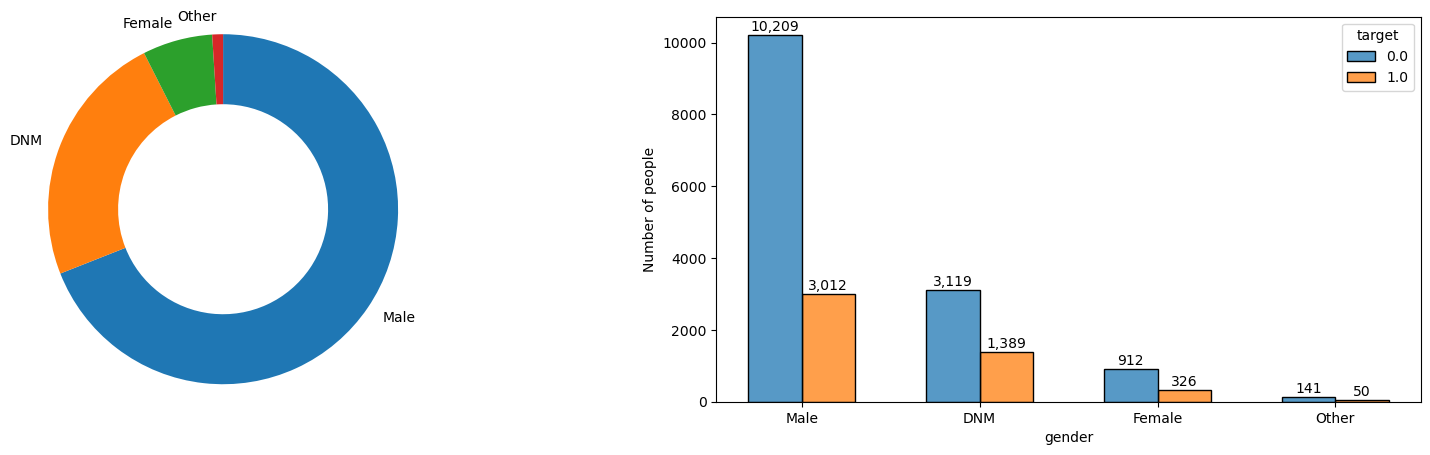

In [15]:
dataset['gender']=dataset['gender'].fillna('DNM')
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
sorted_counts=dataset['gender'].value_counts()
plt.pie(sorted_counts,labels=sorted_counts.index,startangle=90,counterclock=False,wedgeprops={'width':0.4})
plt.axis('square')
plt.subplot(1,2,2)

ax = sns.histplot(data = dataset,x="gender",hue="target",multiple="dodge", shrink = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.show()

For the relationship between gender and target value, we see that male employees have the highest participation in both case of  looking and not looking for a job. Additionally, I replace the missing value in gender with DNM (do not mentioned), and saw that people that do not mention their gender tend to change their job.

### City

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122],
 [Text(0, 0, 'city_103'),
  Text(1, 0, 'city_40'),
  Text(2, 0, 'city_21'),
  Text(3, 0, 'city_115'),
  Text(4, 0, 'city_162'),
  Text(5, 0, 'city_176'),
  Text(6, 0, 'city_160'),
  Text(7, 0, 'city_46'),
  Text(8, 0, 'city_61'),
  Text(9, 0, 'city

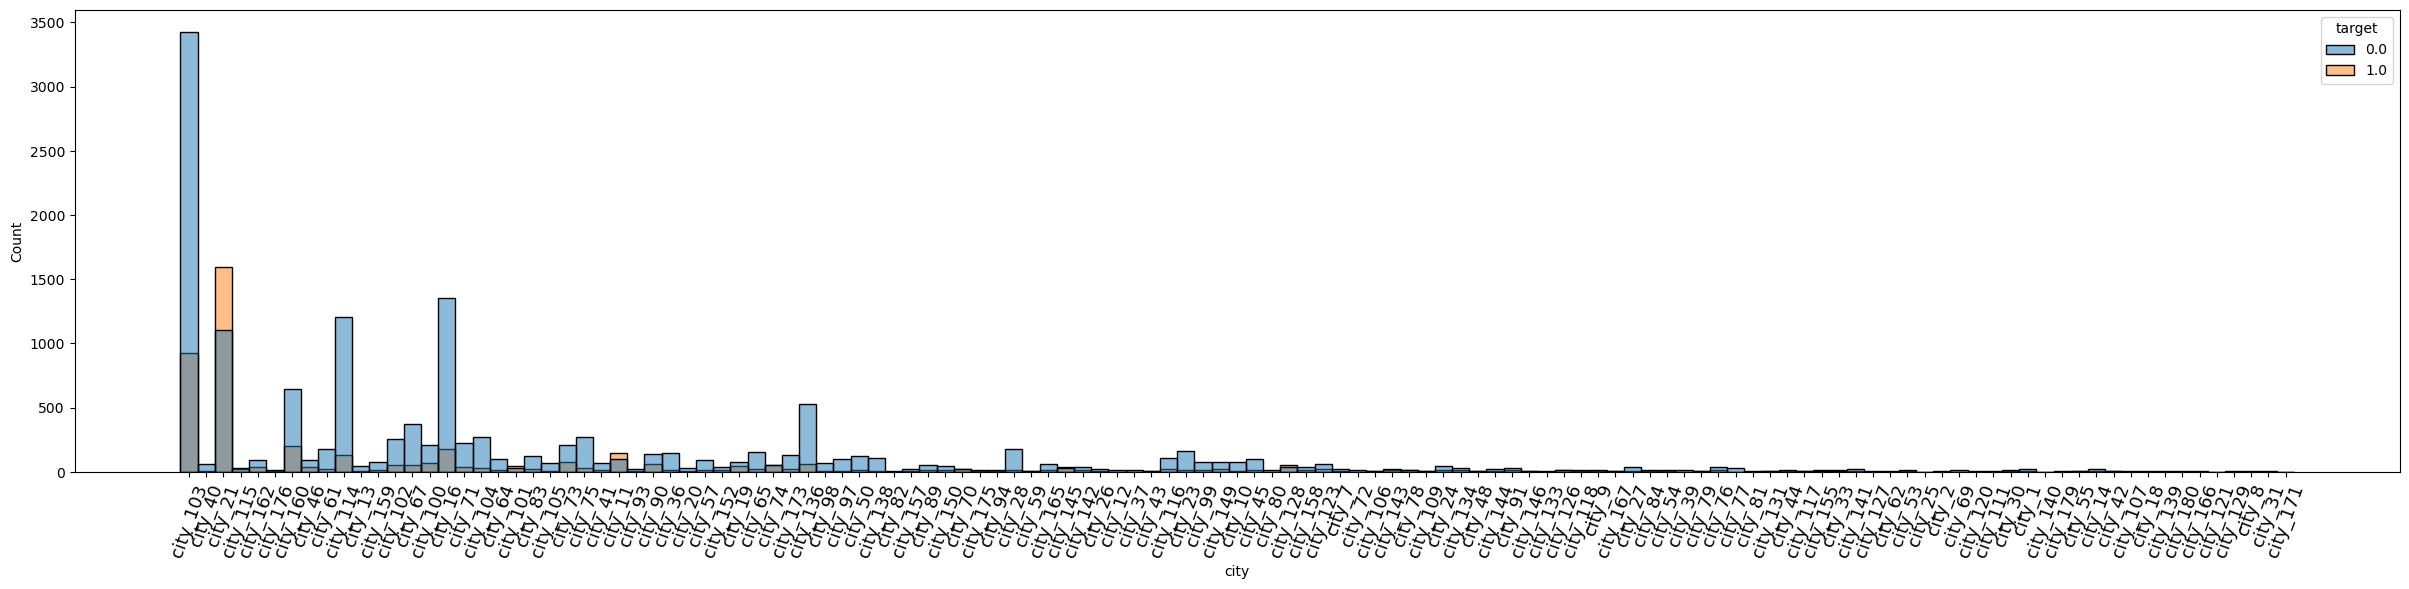

In [16]:
plt.figure(figsize=[30,6])
sns.histplot(data= dataset,  x="city", hue = "target")
plt.xticks(rotation=70,fontsize=13)

I will cut down the amount of city visualization with target, and only get the top city that take up to 80% of the dataset.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'city_103'),
  Text(1, 0, 'city_21'),
  Text(2, 0, 'city_160'),
  Text(3, 0, 'city_61'),
  Text(4, 0, 'city_114'),
  Text(5, 0, 'city_102'),
  Text(6, 0, 'city_67'),
  Text(7, 0, 'city_100'),
  Text(8, 0, 'city_16'),
  Text(9, 0, 'city_71'),
  Text(10, 0, 'city_104'),
  Text(11, 0, 'city_83'),
  Text(12, 0, 'city_73'),
  Text(13, 0, 'city_75'),
  Text(14, 0, 'city_11'),
  Text(15, 0, 'city_90'),
  Text(16, 0, 'city_36'),
  Text(17, 0, 'city_65'),
  Text(18, 0, 'city_173'),
  Text(19, 0, 'city_136'),
  Text(20, 0, 'city_50'),
  Text(21, 0, 'city_28'),
  Text(22, 0, 'city_23')])

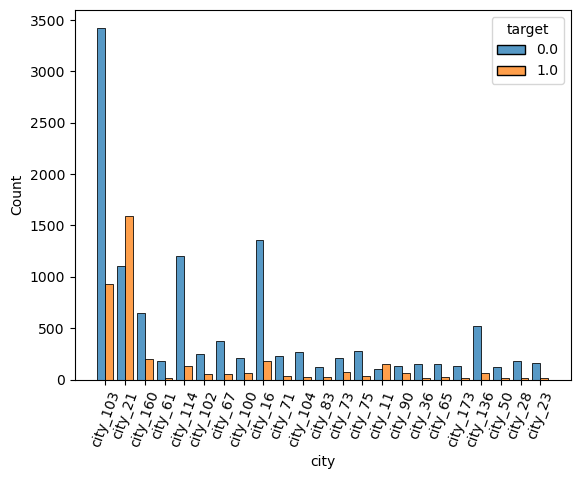

In [17]:
city_count=pd.DataFrame(dataset.city.value_counts().reset_index().values,columns=["city","city_count"])
city_count['count_sum']= city_count['city_count'].cumsum()
city_count['count_sum'] = city_count[city_count['count_sum']<=0.8*19158]['count_sum']

finial_city_count= city_count.dropna()
train_data_w_major_cities = dataset[dataset['city'].isin(finial_city_count['city'])]

sns.histplot(data= train_data_w_major_cities,  x="city", hue = "target",multiple="dodge", shrink=.8)
plt.xticks(rotation=70)


Location might influence whether a person is actively seeking for a new job, possibly due to city development level. We can see that employee from city_21 are most likely to seek for a new job, whereas city_103 experiencing the opposite.

### Relevant experience

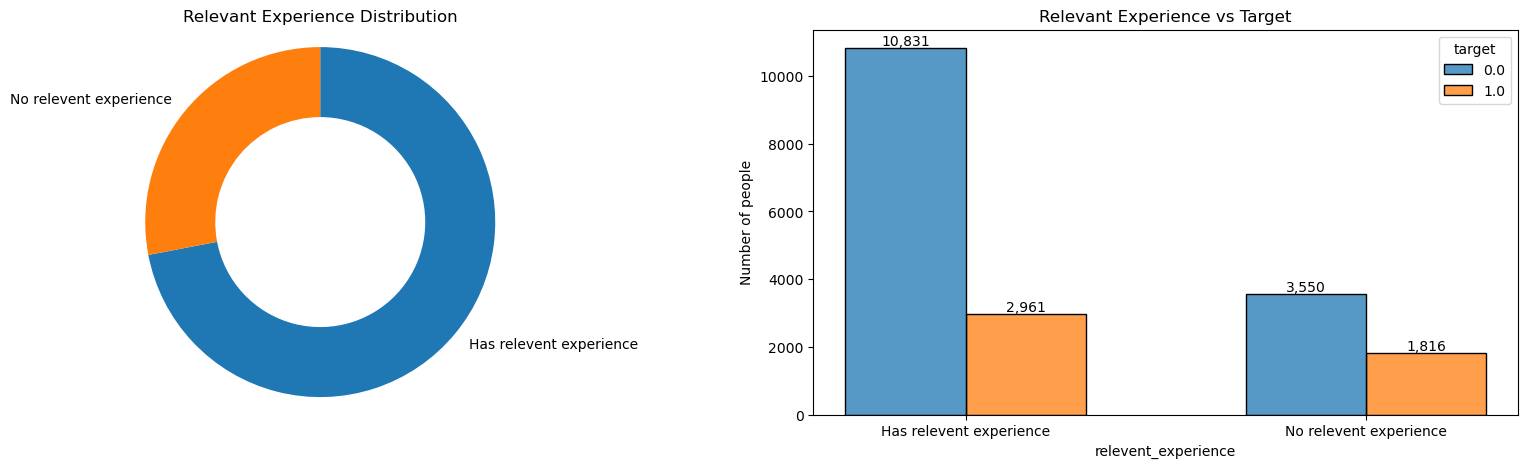

In [18]:
plt.figure(figsize=(20, 5))

# Pie chart of relevant experience
plt.subplot(1, 2, 1)
counts = dataset['relevent_experience'].value_counts()
plt.pie(counts,
        labels=counts.index,
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.4})
plt.axis('square')
plt.title("Relevant Experience Distribution")

# Histogram/barplot with target
plt.subplot(1, 2, 2)
ax = sns.histplot(data=dataset,
                  x="relevent_experience",
                  hue="target",
                  multiple="dodge",
                  shrink=0.6)

# Add numbers on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.ylabel("Number of people")
plt.title("Relevant Experience vs Target")
plt.show()


### Enrolled university (Type of uni enrolled course)

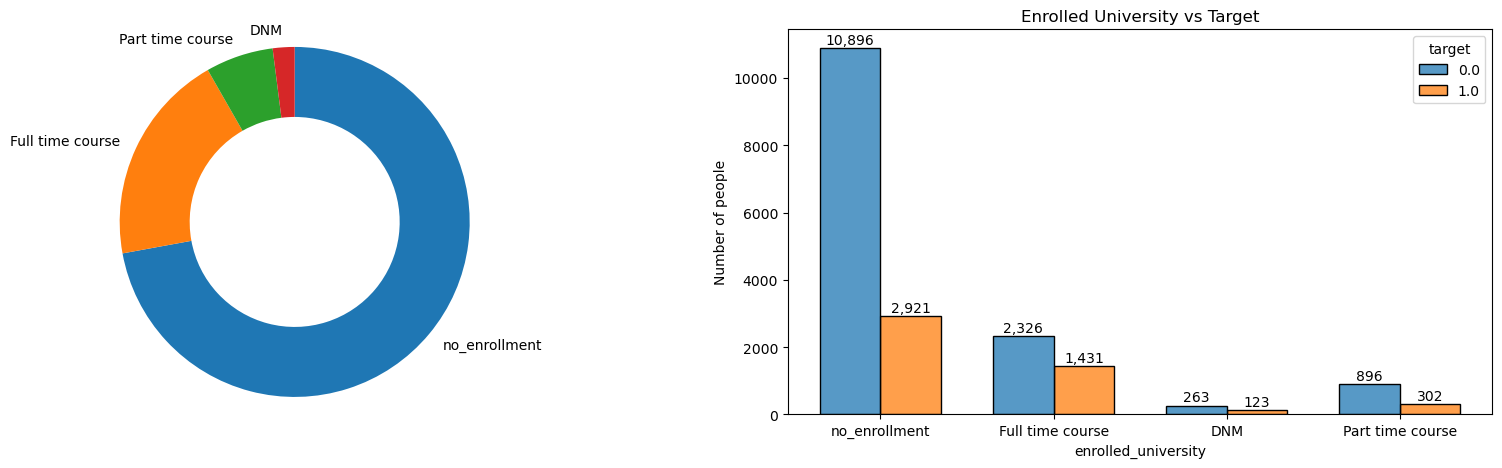

In [19]:
dataset['enrolled_university']=dataset['enrolled_university'].fillna('DNM')
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
sorted_counts = dataset['enrolled_university'].value_counts()

# Pie chart
plt.pie(sorted_counts,labels=sorted_counts.index,startangle=90,counterclock=False,wedgeprops={'width':0.4})
plt.axis('square')

# Count plot
plt.subplot(1,2,2)
ax = sns.histplot(data = dataset,x="enrolled_university",hue="target",multiple="dodge", shrink = 0.7)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.title("Enrolled University vs Target")
plt.show()

### Education level

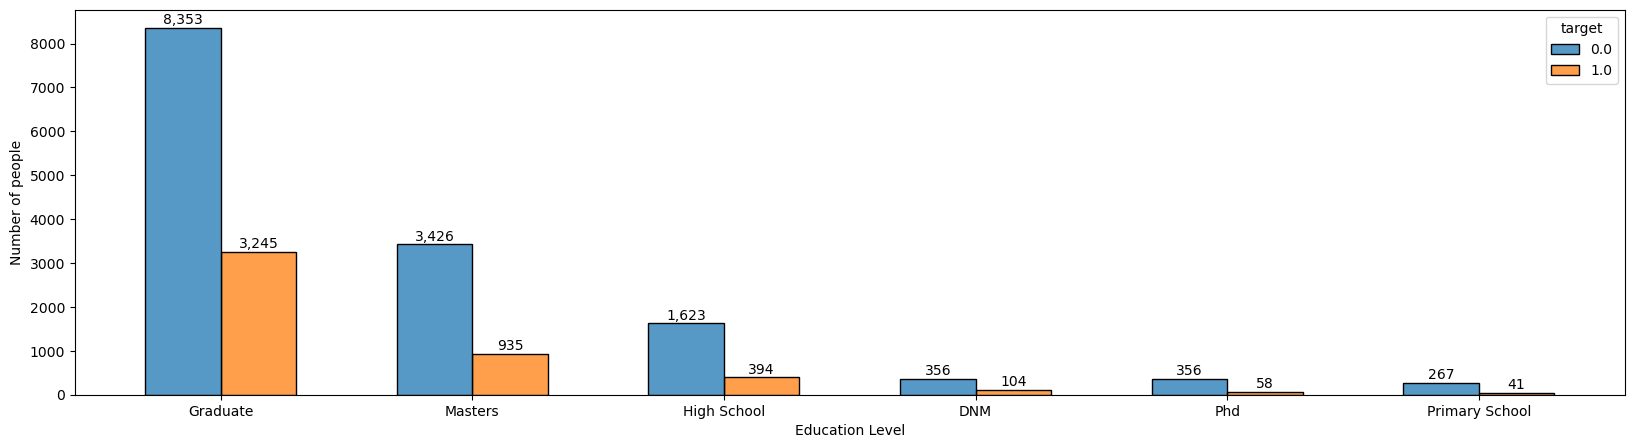

In [20]:
dataset['education_level']=dataset['education_level'].fillna('DNM')
plt.figure(figsize=[20,5])
ax = sns.histplot(data = dataset,x="education_level",hue="target",multiple="dodge", shrink = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.xlabel("Education Level")
plt.show()

In educational level, graduates seem to have the highest number of people looking for a job, in contrast of case like DNM, PhD or Primary School.

### Major discipline

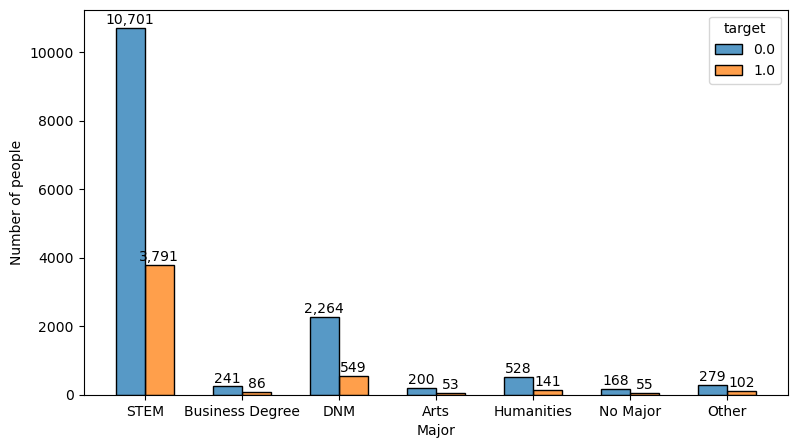

In [21]:
dataset['major_discipline']=dataset['major_discipline'].fillna('DNM')
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ax = sns.histplot(data = dataset,x="major_discipline",hue="target",multiple="dodge", shrink = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.xlabel("Major")
plt.show()

The majority of people that are looking for another job has a background of STEM.

### Experience

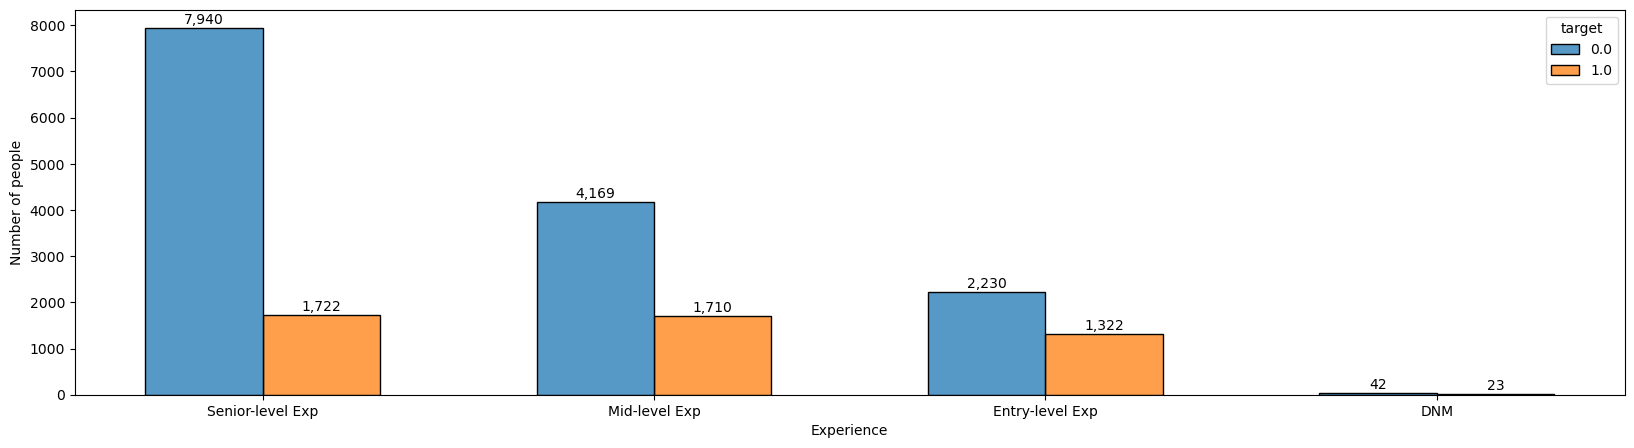

In [22]:
dataset['experience']=dataset['experience'].fillna('DNM')
plt.figure(figsize=[20,5])

dataset['Exp'] = np.where(dataset['experience'].isin(['<1','1','2','3']), "Entry-level Exp", "DNM")
dataset['Exp'] = np.where(dataset['experience'].isin(['4','5','6','7','8']), "Mid-level Exp",dataset['Exp'])
dataset['Exp'] = np.where(dataset['experience'].isin(['9','10','11','12','13','14','15','16','17','18','19','20','>20']), "Senior-level Exp",dataset['Exp'])

ax = sns.histplot(data = dataset,x="Exp",hue="target",multiple="dodge", shrink = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.xlabel("Experience")
plt.show()

Number of people who looking for another job seems to be speaded out in in different experience level, except for those who do not mentioned.

### Company size and type

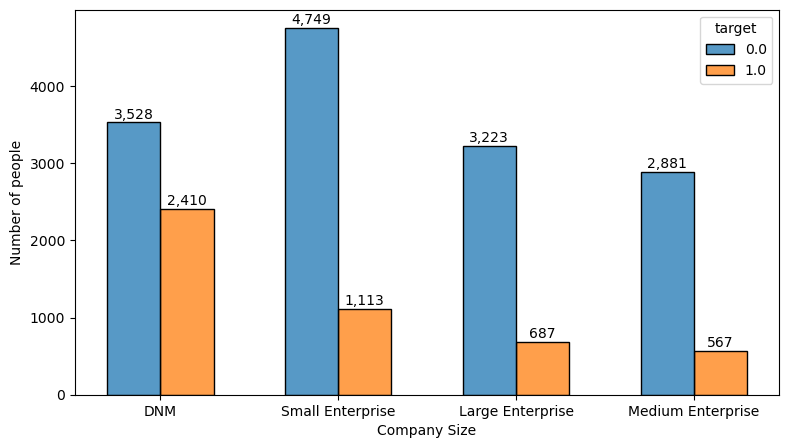

In [23]:
dataset['company_size']=dataset['company_size'].fillna('DNM')
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
dataset['size'] = np.where(dataset['company_size'].isin(['50-99','10/49','<10']), "Small Enterprise", "DNM")
dataset['size'] = np.where(dataset['company_size'].isin(['100-500','500-999']), "Medium Enterprise",dataset['size'])
dataset['size'] = np.where(dataset['company_size'].isin(['10000+','1000-4999','5000-9999']), "Large Enterprise",dataset['size'])

ax = sns.histplot(data = dataset,x="size",hue="target",multiple="dodge", shrink = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.xlabel("Company Size")
plt.show()

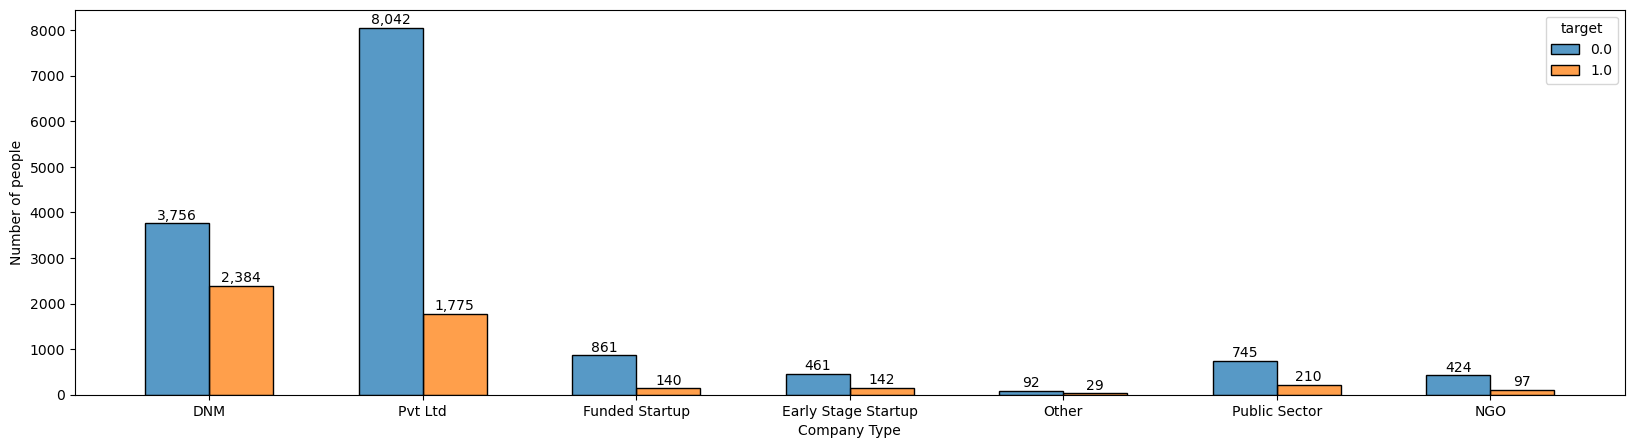

In [24]:
dataset['company_type']=dataset['company_type'].fillna('DNM')
plt.figure(figsize=[20,5])

ax = sns.histplot(data = dataset,x="company_type",hue="target",multiple="dodge", shrink = 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center')

plt.ylabel("Number of people")
plt.xlabel("Company Type")
plt.show()

Candidates that dont want to disclose the status of their current company are likely have a higher chance of finding a new job.

### Training hours

<Axes: xlabel='training_hours', ylabel='Count'>

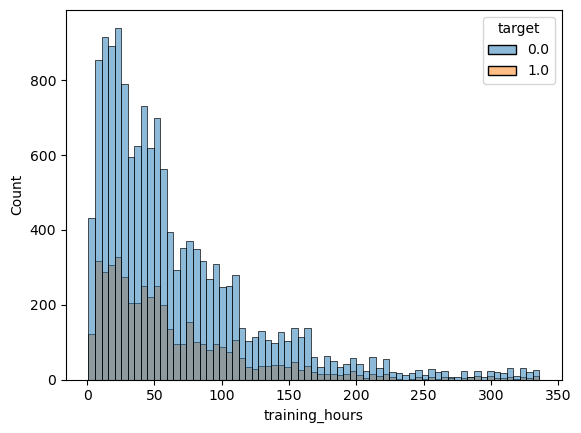

In [4]:
sns.histplot(data= dataset,  x="training_hours", hue = "target")

From all the visualization with target, we can see that the number of people tend to change job are the data that have a null value, indicate that those employees are not interested in the company and tend to not leave their personal information.

# Training model

For the training phase, I like to split into 2 preprocessing approaches to the dataset: 

1. The first approach uses a conventional method, where missing categorical values are replaced with the most frequent category. All categorical attributes are then label-encoded for model compatibility. 

2. The second approach takes a behavioral perspective by assigning missing categorical values as “DNM” (Do Not Mentioned), based on the observation that candidates who omit information may be more likely to seek a job change

The only reason why numeric attribute is not replaced is because there's no missing value in those.

Comparing both preprocessing strategies allows me to have a evaluation of whether standard statistical imputation or behavior-based treatment of missing values leads to better model performance and insight.

And after splitting the dataset, I will apply SMOTE, a technique that generate imbalanced dataset by generating synthetic data. The reason I do this is because in the dataset, the case for people not looking for a job (class 0) is more than that for people taht are looking for new one (class 1), which is the case that we want the model to prioritize to recognize it.

The 2 model were use in this experiment are: Random Forest and XGBoost.

For each model, we will experiment by using RandomSearch to search the hyperparameter, then using grid search based from the best estimator of RandomSearch to choose best hyperparameter.

In [25]:
df = pd.read_csv('dataset/aug_train.csv')

## First approaches

In [26]:
# copy the dataset
data_case1 = df.copy()
data_case1

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


Then, we will replace the missing value in the categorical data with the most frequent value. Then we will encode the categorical data using LabelEncoder.

In [27]:
from sklearn.preprocessing import LabelEncoder

#Categorical column
cat_cols = data_case1.select_dtypes(include='object').columns

# Fill missing value to categorical column with most frequent value
for col in cat_cols:
    mode_val = data_case1[col].mode()[0]
    data_case1[col].fillna(mode_val, inplace=True)

# Encode all categorical
le = LabelEncoder()
for col in cat_cols:
    data_case1[col] = le.fit_transform(data_case1[col])
    
# # check to see if any missing value remain
# print("Remaining missing values:\n", data_case1.isnull().sum())


C:\Users\trung\AppData\Local\Temp\ipykernel_28740\3213638341.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_case1[col].fillna(mode_val, inplace=True)


In [28]:
data_case1

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1,0,2,0,5,21,4,5,0,36,1.0
1,29725,77,0.776,1,1,2,0,5,6,4,5,4,47,0.0
2,11561,64,0.624,1,1,0,0,5,15,4,5,5,83,0.0
3,33241,14,0.789,1,1,2,0,1,20,4,5,5,52,1.0
4,666,50,0.767,1,0,2,2,5,21,4,1,3,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,1,1,2,0,2,5,4,5,0,42,1.0
19154,31398,5,0.920,1,0,2,0,5,5,4,5,3,52,1.0
19155,24576,5,0.920,1,0,2,0,5,21,4,5,3,44,0.0
19156,5756,94,0.802,1,0,2,1,5,20,5,5,1,97,0.0


In [29]:
data_case1.describe()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,44.193914,0.828848,0.945349,0.280092,1.545255,0.689686,4.717768,12.942635,3.355622,4.489560,1.746268,65.366896,0.249348
std,9616.292592,35.464009,0.123362,0.267595,0.449056,0.800123,0.995951,0.950982,6.607340,1.783737,1.297027,1.935640,60.058462,0.432647
min,1.000000,0.000000,0.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8554.250000,5.000000,0.740000,1.000000,0.000000,1.000000,0.000000,5.000000,7.000000,2.000000,5.000000,0.000000,23.000000,0.000000
50%,16982.500000,48.000000,0.903000,1.000000,0.000000,2.000000,0.000000,5.000000,14.000000,4.000000,5.000000,1.000000,47.000000,0.000000
75%,25169.750000,64.000000,0.920000,1.000000,1.000000,2.000000,2.000000,5.000000,19.000000,4.000000,5.000000,4.000000,88.000000,0.000000
max,33380.000000,122.000000,0.949000,2.000000,1.000000,2.000000,4.000000,5.000000,21.000000,7.000000,5.000000,5.000000,336.000000,1.000000


In [30]:
X = data_case1.drop(["enrollee_id","target"],axis=1)
y = data_case1["target"]

In [31]:
# Split the dataset and apply SMOTE after splitting
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Before SMOTE:", y_train.value_counts())

# apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_1, y_train_1 = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_1.value_counts())


Before SMOTE: target
0.0    10081
1.0     3329
Name: count, dtype: int64
After SMOTE: target
0.0    10081
1.0    10081
Name: count, dtype: int64


### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_1 = RandomForestClassifier(random_state=42)

# Hyperparameter grid
rf_param_dist_1 = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, 40, 50, 60],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

rf_random_1 = RandomizedSearchCV(rf_1, param_distributions=rf_param_dist_1, n_iter=20,
                               cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
rf_random_1.fit(X_train, y_train)
print("Best RF params:", rf_random_1.best_params_)
print("Best CV score:", rf_random_1.best_score_)

Best RF params: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 459}
Best CV score: 0.7861297539149888


Nex step, I will take the best RandomForest configuration and use them to explore slightly higher and lower values for each key parameter using Grid Search to find the optimal combination for the dataset.

In [33]:
from sklearn.model_selection import GridSearchCV

rf_best_params_1 = rf_random_1.best_params_

rf_param_grid_1 = {
    'n_estimators': [rf_best_params_1['n_estimators']-50, rf_best_params_1['n_estimators'], rf_best_params_1['n_estimators']+50],
    'max_depth': [rf_best_params_1['max_depth']-2, rf_best_params_1['max_depth'], rf_best_params_1['max_depth']+2],
    'min_samples_split': [rf_best_params_1['min_samples_split']-1, rf_best_params_1['min_samples_split'], rf_best_params_1['min_samples_split']+1],
    'min_samples_leaf': [rf_best_params_1['min_samples_leaf'], rf_best_params_1['min_samples_leaf']+1, rf_best_params_1['min_samples_leaf']+2],
    'max_features' : [rf_best_params_1['max_features']]
}

rf_grid_1 = GridSearchCV(rf_1, param_grid=rf_param_grid_1, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_1.fit(X_train_1, y_train_1)
print("Best RF Grid params:", rf_grid_1.best_params_)

Best RF Grid params: {'max_depth': 32, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 409}


In [34]:
y_pred_rf_1 = rf_grid_1.best_estimator_.predict(X_test)
print('Train Score is : ' , rf_grid_1.best_estimator_.score(X_train_1, y_train_1))
print('Test Score is : ' , rf_grid_1.best_estimator_.score(X_test, y_test))

Train Score is :  0.8393016565816883
Test Score is :  0.7411273486430062


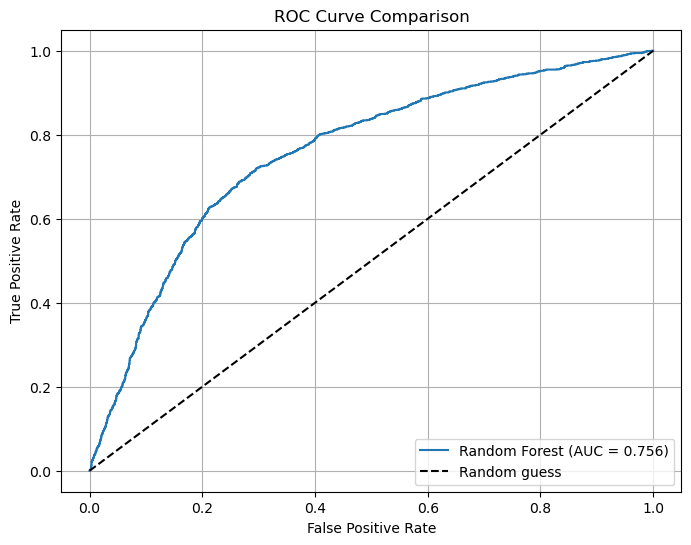

In [87]:
y_proba_rf_1 = rf_grid_1.best_estimator_.predict_proba(X_test)[:, 1]
fpr_rf_1, tpr_rf_1, _ = roc_curve(y_test, y_proba_rf_1)
auc_rf_1 = roc_auc_score(y_test, y_proba_rf_1)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_1, tpr_rf_1, label=f"Random Forest (AUC = {auc_rf_1:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

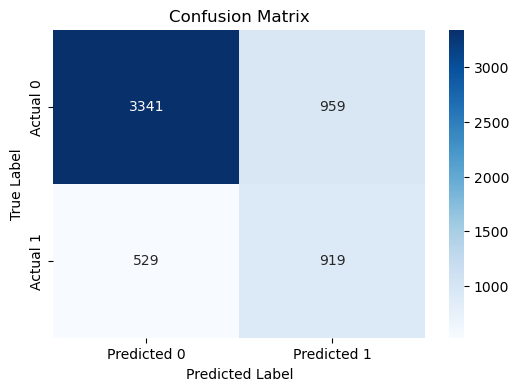

In [35]:
cm = confusion_matrix(y_test, y_pred_rf_1, labels=[0,1])
cm_df = pd.DataFrame(cm,
                     index=['Actual 0','Actual 1'],
                     columns=['Predicted 0','Predicted 1'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

True Negatives (TN) = 3819 → Actual 0 predicted as 0

False Positives (FP) = 959 → Actual 0 predicted as 1

False Negatives (FN) = 529 → Actual 1 predicted as 0

True Positives (TP) = 919 → Actual 1 predicted as 1

In [36]:
print("\nRandom Forest classification Report:\n")
print(classification_report(y_test, y_pred_rf_1, digits=4))


Random Forest classification Report:

              precision    recall  f1-score   support

         0.0     0.8633    0.7770    0.8179      4300
         1.0     0.4894    0.6347    0.5526      1448

    accuracy                         0.7411      5748
   macro avg     0.6763    0.7058    0.6852      5748
weighted avg     0.7691    0.7411    0.7510      5748



The classification report show that it can predict good classification on class 0, but extremely bad on class 1 even with the SMOTE technique (only capture 63% of the actual case).

In [37]:
# I ask ChatGPT to create for me a feature importance function
# To see which feature it use for evaluation
def FeatureImportances(model, X_train, y_train):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Extract feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for all features
    imp = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Add cumulative importance
    imp['Cumulative Importance'] = imp['Importance'].cumsum()
    
    return imp

In [38]:
rf_importances_1 = FeatureImportances(rf_grid_1.best_estimator_, X_train_1, y_train_1)
print(rf_importances_1)

                   Feature  Importance  Cumulative Importance
1   city_development_index    0.317233               0.317233
0                     city    0.119009               0.436242
4      enrolled_university    0.117972               0.554214
8             company_size    0.100054               0.654268
11          training_hours    0.091123               0.745390
7               experience    0.074387               0.819778
5          education_level    0.069726               0.889503
10            last_new_job    0.042942               0.932446
9             company_type    0.029214               0.961660
3      relevent_experience    0.015413               0.977073
6         major_discipline    0.013892               0.990966
2                   gender    0.009034               1.000000


### XGBoost

Now we gonna repeat the process using XGBoost model.

In [39]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Base model
xgb_1 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Define parameter distributions for random search
xgb_param_dist_1 = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 6)
}

# Randomized Search
xgb_random_1 = RandomizedSearchCV(estimator=xgb_1,param_distributions=xgb_param_dist_1,
                                n_iter=20,scoring='accuracy',cv=5,verbose=1,
                                random_state=42,n_jobs=-1
)

xgb_random_1.fit(X_train_1, y_train_1)

print("Best params from Random Search (XGBoost):", xgb_random_1.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\trung\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:43:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params from Random Search (XGBoost): {'colsample_bytree': 0.9282355145850691, 'learning_rate': 0.12225543951389925, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 236, 'subsample': 0.9131988669057362}


In [40]:
# Get best params from random search
xgb_best_params_1 = xgb_random_1.best_params_

xgb_param_grid_1 = {
    'n_estimators': [xgb_best_params_1['n_estimators']-50, xgb_best_params_1['n_estimators'], xgb_best_params_1['n_estimators']+50],
    'max_depth': [xgb_best_params_1['max_depth']-2, xgb_best_params_1['max_depth'], xgb_best_params_1['max_depth']+2],
    'learning_rate': [xgb_best_params_1['learning_rate']*0.8, xgb_best_params_1['learning_rate'], xgb_best_params_1['learning_rate']*1.2],
    'subsample': [max(0.1, xgb_best_params_1['subsample']-0.1), xgb_best_params_1['subsample'], min(1.0, xgb_best_params_1['subsample']+0.1)],
    'colsample_bytree': [max(0.1, xgb_best_params_1['colsample_bytree']-0.1), xgb_best_params_1['colsample_bytree'], min(1.0, xgb_best_params_1['colsample_bytree']+0.1)],
    'min_child_weight': [xgb_best_params_1['min_child_weight']-1, xgb_best_params_1['min_child_weight'], xgb_best_params_1['min_child_weight']+1]
}

# Grid Search
xgb_grid_1 = GridSearchCV(estimator=xgb_1,param_grid=xgb_param_grid_1,
                        scoring='accuracy',cv=5,verbose=1,n_jobs=-1
)

xgb_grid_1.fit(X_train_1, y_train_1)

print("Best params from Grid Search (XGBoost):", xgb_grid_1.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\trung\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params from Grid Search (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.14670652741667908, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 286, 'subsample': 0.9131988669057362}


In [41]:
y_pred_xgb_1 = xgb_grid_1.best_estimator_.predict(X_test)
print('Train Score is : ' , xgb_grid_1.best_estimator_.score(X_train_1, y_train_1))
print('Test Score is : ' , xgb_grid_1.best_estimator_.score(X_test, y_test))

Train Score is :  0.9879972224977681
Test Score is :  0.7345163535142658


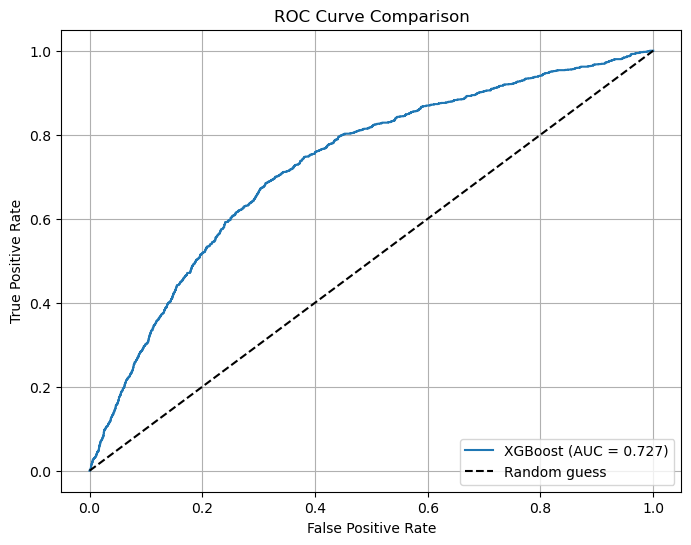

In [90]:
y_proba_xgb_1 = xgb_grid_1.best_estimator_.predict_proba(X_test)[:, 1]
fpr_xgb_1, tpr_xgb_1, _ = roc_curve(y_test, y_proba_xgb_1)
auc_xgb_1 = roc_auc_score(y_test, y_proba_xgb_1)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb_1, tpr_xgb_1, label=f"XGBoost (AUC = {auc_xgb_1:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

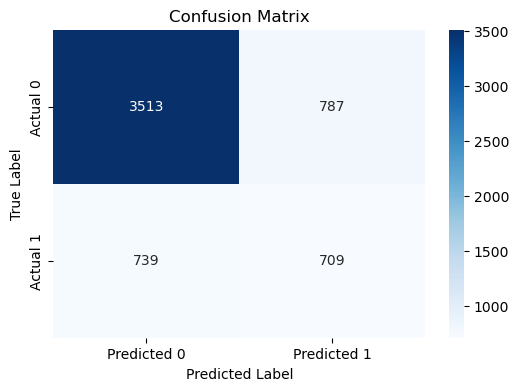

In [42]:
cm = confusion_matrix(y_test, y_pred_xgb_1, labels=[0,1])
cm_df = pd.DataFrame(cm,
                     index=['Actual 0','Actual 1'],
                     columns=['Predicted 0','Predicted 1'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

True Negatives (TN) = 3513 → Actual 0 predicted as 0

False Positives (FP) = 787 → Actual 0 predicted as 1

False Negatives (FN) = 739 → Actual 1 predicted as 0

True Positives (TP) = 709 → Actual 1 predicted as 1

In [43]:
print("\nXGB classification Report:\n")
print(classification_report(y_test, y_pred_xgb_1, digits=4))


XGB classification Report:

              precision    recall  f1-score   support

         0.0     0.8262    0.8170    0.8216      4300
         1.0     0.4739    0.4896    0.4817      1448

    accuracy                         0.7345      5748
   macro avg     0.6501    0.6533    0.6516      5748
weighted avg     0.7375    0.7345    0.7359      5748



The performance of XGB model slightly worse compared to RF model, with recall only 48%, when RF offer 63%.

In [44]:
xgb_importances_1 = FeatureImportances(xgb_grid_1.best_estimator_, X_train_1, y_train_1)
print(xgb_importances_1)

c:\Users\trung\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                   Feature  Importance  Cumulative Importance
1   city_development_index    0.173866               0.173866
4      enrolled_university    0.142975               0.316841
8             company_size    0.094008               0.410849
5          education_level    0.088945               0.499794
9             company_type    0.085055               0.584849
2                   gender    0.070794               0.655643
0                     city    0.066630               0.722273
6         major_discipline    0.066247               0.788520
3      relevent_experience    0.059592               0.848111
10            last_new_job    0.053323               0.901435
11          training_hours    0.049560               0.950994
7               experience    0.049006               1.000000


## Second approaches

Now we gonna test our theory based on the visualization to see if our performance get better.

In [63]:
data_case2 = df.copy()
data_case2

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


Since all of the value that is missing is categorical, I am going to change all null value into DNM (Do not mentioned), and label encode to 'city' attribute.

In [64]:
#Categorical column
cat_cols = data_case2.select_dtypes(include='object').columns

# Fill missing value to categorical column with most frequent value
for col in cat_cols:
    data_case2[col].fillna('DNM', inplace=True)

le = LabelEncoder()
data_case2['city'] = le.fit_transform(data_case2['city'])


C:\Users\trung\AppData\Local\Temp\ipykernel_28740\763129077.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_case2[col].fillna('DNM', inplace=True)


Then, I group experience levels into 4 category: Entry-level, Mid-level, Senior level and DNM.

In [65]:
# Group experience into categories
data_case2['experience'] = np.where(data_case2['experience'].isin(['<1', '1', '2', '3']), "Entry-level Exp", data_case2['experience'])
data_case2['experience'] = np.where(data_case2['experience'].isin(['4', '5', '6', '7', '8']), "Mid-level Exp", data_case2['experience'])
data_case2['experience'] = np.where(data_case2['experience'].isin(
    ['9','10','11','12','13','14','15','16','17','18','19','20','>20']), 
    "Senior-level Exp", data_case2['experience'])


The same goes to company size as well.

In [66]:
# Group company size into categories
data_case2['company_size'] = np.where(data_case2['company_size'].isin(['50-99', '10/49', '<10']), "Small Enterprise", data_case2['company_size'])
data_case2['company_size'] = np.where(data_case2['company_size'].isin(['100-500', '500-999']), "Medium Enterprise", data_case2['company_size'])
data_case2['company_size'] = np.where(data_case2['company_size'].isin(['10000+', '1000-4999', '5000-9999']), "Large Enterprise", data_case2['company_size'])

In [67]:
data_case2

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,Senior-level Exp,DNM,DNM,1,36,1.0
1,29725,77,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,Senior-level Exp,Small Enterprise,Pvt Ltd,>4,47,0.0
2,11561,64,0.624,DNM,No relevent experience,Full time course,Graduate,STEM,Mid-level Exp,DNM,DNM,never,83,0.0
3,33241,14,0.789,DNM,No relevent experience,DNM,Graduate,Business Degree,Entry-level Exp,DNM,Pvt Ltd,never,52,1.0
4,666,50,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,Senior-level Exp,Small Enterprise,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,Senior-level Exp,DNM,DNM,1,42,1.0
19154,31398,5,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,Senior-level Exp,DNM,DNM,4,52,1.0
19155,24576,5,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,Senior-level Exp,Small Enterprise,Pvt Ltd,4,44,0.0
19156,5756,94,0.802,Male,Has relevent experience,no_enrollment,High School,DNM,Entry-level Exp,Medium Enterprise,Pvt Ltd,2,97,0.0


Lastly, I encode categorical attributes manually.

In [68]:
# Encode categorical data using numerical mapping
replace_dict = {
    'gender': {'Male': 0, 'Female': 1, 'DNM': 2, 'Other': 3},
    'enrolled_university': {'no_enrollment': 0, 'Full time course': 1, 'Part time course': 2, 'DNM': 3},
    'relevent_experience': {'No relevent experience': 0, 'Has relevent experience': 1},
    'education_level': {'Graduate': 3, 'High School': 2, 'Primary School': 1, 'Masters': 4, 'Phd': 5, 'DNM': 0},
    'major_discipline': {'STEM': 1, 'Humanities': 2, 'Arts': 3, 'Business Degree': 4, 'No Major': 5, 'Other': 6, 'DNM': 7},
    'experience': {'Entry-level Exp': 1, 'Mid-level Exp': 2, 'Senior-level Exp': 3, 'DNM': 4},
    'company_size': {'Small Enterprise': 1, 'Medium Enterprise': 2, 'Large Enterprise': 3, 'DNM': 4},
    'last_new_job': {'>4': 5, '1': 1, 'never': 0, '4': 4, '3': 3, '2': 2, 'DNM': 6},
    'company_type': {'Pvt Ltd': 1, 'Funded Startup': 2, 'Public Sector': 3, 'Early Stage Startup': 4, 'NGO': 5, 'Other': 6, 'DNM': 7}
}

for col, mapping in replace_dict.items():
    data_case2[col] = data_case2[col].replace(mapping)

C:\Users\trung\AppData\Local\Temp\ipykernel_28740\177321117.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_case2[col] = data_case2[col].replace(mapping)


In [69]:
data_case2

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,0,1,0,3,1,3,4,7,1,36,1.0
1,29725,77,0.776,0,0,0,3,1,3,1,1,5,47,0.0
2,11561,64,0.624,2,0,1,3,1,2,4,7,0,83,0.0
3,33241,14,0.789,2,0,3,3,4,1,4,1,0,52,1.0
4,666,50,0.767,0,1,0,4,1,3,1,2,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,55,0.878,0,0,0,3,2,3,4,7,1,42,1.0
19154,31398,5,0.920,0,1,0,3,1,3,4,7,4,52,1.0
19155,24576,5,0.920,0,1,0,3,1,3,1,1,4,44,0.0
19156,5756,94,0.802,0,1,0,2,7,1,2,1,2,97,0.0


In [70]:
data_case2.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [71]:
data_case2.describe()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,44.193914,0.828848,0.565142,0.719908,0.381616,3.061384,2.139524,2.325712,2.518008,3.309688,2.088736,65.366896,0.249348
std,9616.292592,35.464009,0.123362,0.881038,0.449056,0.694237,0.834283,2.216408,0.772821,1.217216,2.707656,1.758137,60.058462,0.432647
min,1.000000,0.000000,0.448000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,8554.250000,5.000000,0.740000,0.000000,0.000000,0.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,23.000000,0.000000
50%,16982.500000,48.000000,0.903000,0.000000,1.000000,0.000000,3.000000,1.000000,3.000000,3.000000,1.000000,1.000000,47.000000,0.000000
75%,25169.750000,64.000000,0.920000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000,4.000000,7.000000,3.000000,88.000000,0.000000
max,33380.000000,122.000000,0.949000,3.000000,1.000000,3.000000,5.000000,7.000000,4.000000,4.000000,7.000000,6.000000,336.000000,1.000000


In [72]:
X2 = data_case2.drop(["enrollee_id", "target"],axis=1)
y2 = data_case2["target"]

In [73]:
# Split the dataset and apply SMOTE after splitting
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
    
X_train, X_test_2, y_train, y_test_2 = train_test_split(X2, y2, test_size=0.3, random_state=42)
print("Before SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_2, y_train_2 = smote.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_2.value_counts())


Before SMOTE: target
0.0    10081
1.0     3329
Name: count, dtype: int64
After SMOTE: target
0.0    10081
1.0    10081
Name: count, dtype: int64


In this experiment, I will apply the same techique that were done in the first approach.

### Random Forest


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_2 = RandomForestClassifier(random_state=42)

# Hyperparameter grid
rf_param_dist_2 = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, 40, 50, 60],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

rf_random_2 = RandomizedSearchCV(rf_2, param_distributions=rf_param_dist_2, n_iter=20,
                               cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
rf_random_2.fit(X_train_2, y_train_2)
print("Best RF params:", rf_random_2.best_params_)
print("Best CV score:", rf_random_2.best_score_)

Best RF params: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 149}
Best CV score: 0.8249738516366957


In [75]:
from sklearn.model_selection import GridSearchCV

rf_best_params_2 = rf_random_2.best_params_

rf_param_grid_2 = {
    'n_estimators': [rf_best_params_2['n_estimators']-50, rf_best_params_2['n_estimators'], rf_best_params_2['n_estimators']+50],
    'max_depth': [rf_best_params_2['max_depth']-2, rf_best_params_2['max_depth'], rf_best_params_2['max_depth']+2],
    'min_samples_split': [rf_best_params_2['min_samples_split']-1, rf_best_params_2['min_samples_split'], rf_best_params_2['min_samples_split']+1],
    'min_samples_leaf': [rf_best_params_2['min_samples_leaf'], rf_best_params_2['min_samples_leaf']+1, rf_best_params_2['min_samples_leaf']+2],
    'max_features' : [rf_best_params_2['max_features']]
}

rf_grid_2 = GridSearchCV(rf_2, param_grid=rf_param_grid_2, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_2.fit(X_train_2, y_train_2)
print("Best RF Grid params:", rf_grid_2.best_params_)

Best RF Grid params: {'max_depth': 28, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 199}


In [76]:
y_pred_rf_2 = rf_grid_2.best_estimator_.predict(X_test_2)
print('Train Score is : ' , rf_grid_2.best_estimator_.score(X_train_2, y_train_2))
print('Test Score is : ' , rf_grid_2.best_estimator_.score(X_test_2, y_test_2))

Train Score is :  0.9758456502331118
Test Score is :  0.7640918580375783


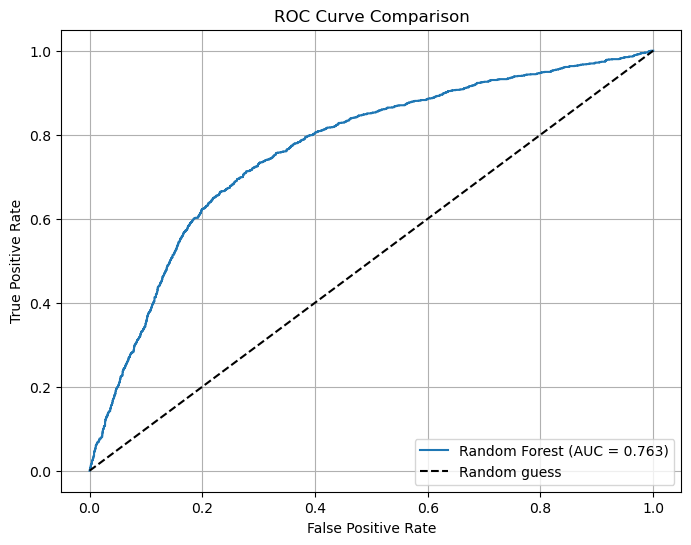

In [89]:
y_proba_rf_2 = rf_grid_2.best_estimator_.predict_proba(X_test_2)[:, 1]
fpr_rf_2, tpr_rf_2, _ = roc_curve(y_test_2, y_proba_rf_2)
auc_rf_2 = roc_auc_score(y_test_2, y_proba_rf_2)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf_2, tpr_rf_2, label=f"Random Forest (AUC = {auc_rf_2:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

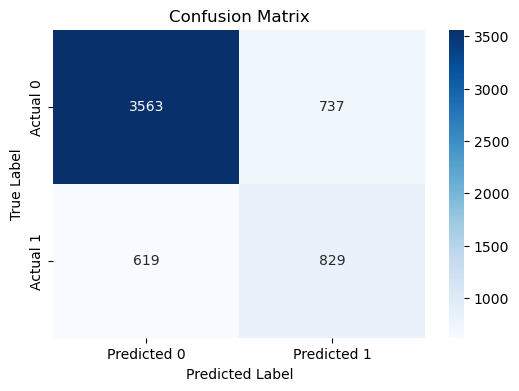

In [77]:
cm_2 = confusion_matrix(y_test_2, y_pred_rf_2, labels=[0,1])
cm_df_2 = pd.DataFrame(cm_2,
                     index=['Actual 0','Actual 1'],
                     columns=['Predicted 0','Predicted 1'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df_2, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

True Negatives (TN) = 3563 → Actual 0 predicted as 0

False Positives (FP) = 737 → Actual 0 predicted as 1

False Negatives (FN) = 619 → Actual 1 predicted as 0

True Positives (TP) = 829 → Actual 1 predicted as 1

In [78]:
print("\nRandom Forest classification Report:\n")
print(classification_report(y_test_2, y_pred_rf_2, digits=4))


Random Forest classification Report:

              precision    recall  f1-score   support

         0.0     0.8520    0.8286    0.8401      4300
         1.0     0.5294    0.5725    0.5501      1448

    accuracy                         0.7641      5748
   macro avg     0.6907    0.7006    0.6951      5748
weighted avg     0.7707    0.7641    0.7671      5748



In [79]:
rf_importances_2 = FeatureImportances(rf_grid_2.best_estimator_, X_train_2, y_train_2)
print(rf_importances_2)

                   Feature  Importance  Cumulative Importance
1   city_development_index    0.227696               0.227696
11          training_hours    0.190554               0.418249
0                     city    0.106392               0.524641
7               experience    0.070038               0.594679
8             company_size    0.068445               0.663125
9             company_type    0.066546               0.729671
10            last_new_job    0.062465               0.792136
6         major_discipline    0.051577               0.843714
5          education_level    0.046979               0.890692
3      relevent_experience    0.043135               0.933827
2                   gender    0.033466               0.967293
4      enrolled_university    0.032707               1.000000


### XGBoost

In [80]:
# Base model
xgb_2 = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Define parameter distributions for random search
xgb_param_dist_2 = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 6)
}

# Randomized Search
xgb_random_2 = RandomizedSearchCV(estimator=xgb_2,param_distributions=xgb_param_dist_2,
                                n_iter=20,scoring='accuracy',cv=5,verbose=1,
                                random_state=42,n_jobs=-1
)

xgb_random_2.fit(X_train_2, y_train_2)

print("Best params from Random Search (XGBoost):", xgb_random_2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\trung\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:59:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params from Random Search (XGBoost): {'colsample_bytree': 0.9282355145850691, 'learning_rate': 0.12225543951389925, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 236, 'subsample': 0.9131988669057362}


In [81]:
# Get best params from random search
xgb_best_params_2 = xgb_random_2.best_params_

xgb_param_grid_2 = {
    'n_estimators': [xgb_best_params_2['n_estimators']-50, xgb_best_params_2['n_estimators'], xgb_best_params_2['n_estimators']+50],
    'max_depth': [xgb_best_params_2['max_depth']-2, xgb_best_params_2['max_depth'], xgb_best_params_2['max_depth']+2],
    'learning_rate': [xgb_best_params_2['learning_rate']*0.8, xgb_best_params_2['learning_rate'], xgb_best_params_2['learning_rate']*1.2],
    'subsample': [max(0.1, xgb_best_params_2['subsample']-0.1), xgb_best_params_2['subsample'], min(1.0, xgb_best_params_2['subsample']+0.1)],
    'colsample_bytree': [max(0.1, xgb_best_params_2['colsample_bytree']-0.1), xgb_best_params_2['colsample_bytree'], min(1.0, xgb_best_params_2['colsample_bytree']+0.1)],
    'min_child_weight': [xgb_best_params_2['min_child_weight']-1, xgb_best_params_2['min_child_weight'], xgb_best_params_2['min_child_weight']+1]
}

# Grid Search
xgb_grid_2 = GridSearchCV(estimator=xgb_2,param_grid=xgb_param_grid_2,
                        scoring='accuracy',cv=5,verbose=1,n_jobs=-1
)

xgb_grid_2.fit(X_train_2, y_train_2)

print("Best params from Grid Search (XGBoost):", xgb_grid_2.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\trung\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:05:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params from Grid Search (XGBoost): {'colsample_bytree': 1.0, 'learning_rate': 0.0978043516111194, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 286, 'subsample': 0.9131988669057362}


In [82]:
y_pred_xgb_2 = xgb_grid_2.best_estimator_.predict(X_test_2)
print('Train Score is : ' , xgb_grid_2.best_estimator_.score(X_train_2, y_train_2))
print('Test Score is : ' , xgb_grid_2.best_estimator_.score(X_test_2, y_test_2))

Train Score is :  0.975647257216546
Test Score is :  0.7529575504523313


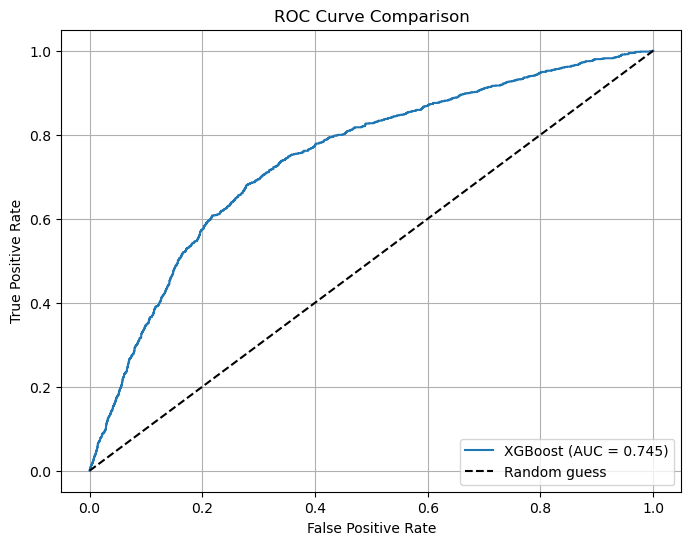

In [91]:
y_proba_xgb_2 = xgb_grid_2.best_estimator_.predict_proba(X_test_2)[:, 1]
fpr_xgb_2, tpr_xgb_2, _ = roc_curve(y_test_2, y_proba_xgb_2)
auc_xgb_2 = roc_auc_score(y_test_2, y_proba_xgb_2)

plt.figure(figsize=(8,6))
plt.plot(fpr_xgb_2, tpr_xgb_2, label=f"XGBoost (AUC = {auc_xgb_2:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

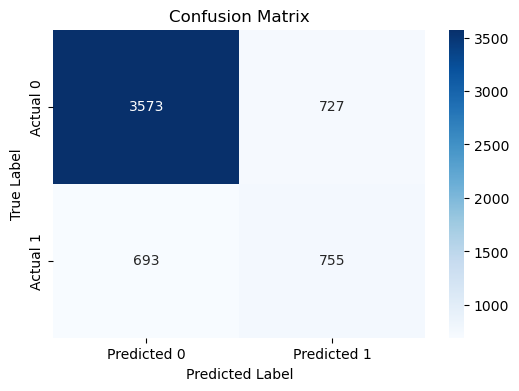

In [83]:
cm_2 = confusion_matrix(y_test_2, y_pred_xgb_2, labels=[0,1])
cm_df_2 = pd.DataFrame(cm_2,
                     index=['Actual 0','Actual 1'],
                     columns=['Predicted 0','Predicted 1'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_df_2, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

True Negatives (TN) = 3573 → Actual 0 predicted as 0

False Positives (FP) = 727 → Actual 0 predicted as 1

False Negatives (FN) = 693 → Actual 1 predicted as 0

True Positives (TP) = 755 → Actual 1 predicted as 1

In [84]:
print("\nXGB classification Report:\n")
print(classification_report(y_test_2, y_pred_xgb_2, digits=4))


XGB classification Report:

              precision    recall  f1-score   support

         0.0     0.8376    0.8309    0.8342      4300
         1.0     0.5094    0.5214    0.5154      1448

    accuracy                         0.7530      5748
   macro avg     0.6735    0.6762    0.6748      5748
weighted avg     0.7549    0.7530    0.7539      5748



In [85]:
xgb_importances_2 = FeatureImportances(xgb_grid_2.best_estimator_, X_train_2, y_train_2)
print(xgb_importances_2)

c:\Users\trung\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:05:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                   Feature  Importance  Cumulative Importance
1   city_development_index    0.154887               0.154887
6         major_discipline    0.129807               0.284694
9             company_type    0.128153               0.412847
3      relevent_experience    0.119383               0.532230
5          education_level    0.090525               0.622755
7               experience    0.060211               0.682966
2                   gender    0.059635               0.742601
8             company_size    0.057584               0.800185
0                     city    0.055693               0.855878
4      enrolled_university    0.054932               0.910810
10            last_new_job    0.045570               0.956380
11          training_hours    0.043620               1.000000
